# RATP Map

The goal here is to make a map of the distance between points for a graphic representation of time of transit

First things first, we need to get all the stations and their coordinates. We will only focus on Metro stations. 

## Metro stations


In [2]:
from lxml import html
import requests
import pandas as pd
import pickle

pd.set_option('max_colwidth',200)

page = requests.get('https://fr.wikipedia.org/wiki/Liste_des_stations_du_m%C3%A9tro_de_Paris')
tree = html.fromstring(page.content)
tr_elements = tree.xpath('//tr')

def getLocfromUrl(url):
    page = requests.get(url)
    tree = html.fromstring(page.content)
    tr_elements = tree.xpath('//a[@class="mw-kartographer-maplink"]')
    return(float(tr_elements[0].get("data-lat")),float(tr_elements[0].get("data-lon")))

df  = pd.DataFrame()
try:
    with open('data/metro.pkl', 'rb') as f:
        df = pickle.load(f)
except FileNotFoundError:
    for j in range(1,len(tr_elements)):
        T=tr_elements[j]
        #If row is not of size 10, the //tr data is not from our table 
        if len(T)!=10:
            break
        city=T[5].text_content().strip('\u200d').strip('\n')
        if "Paris" in city: 
            city="Paris"
        name=T[0].text_content().strip('\u200d').strip('\n')+" (METRO), "+city
        url="https://fr.wikipedia.org/"+ T[0].xpath('a')[0].get('href')
        df = df.append({'stationName': name, 'url': url, 'location': getLocfromUrl(url)}, ignore_index=True)
    df.to_pickle("data/metro.pkl")
    
print(df.head())


                             location  \
0  (48.884417645184, 2.3387128116588)   
1  (48.828398514348, 2.3267456737192)   
2  (48.856174448968, 2.3949898158233)   
3               (48.864904, 2.300234)   
4               (48.892022, 2.285536)   

                                stationName  \
0                   Abbesses (METRO), Paris   
1                     Alésia (METRO), Paris   
2            Alexandre Dumas (METRO), Paris   
3             Alma - Marceau (METRO), Paris   
4  Anatole France (METRO), Levallois-Perret   

                                                                    url  
0         https://fr.wikipedia.org//wiki/Abbesses_(m%C3%A9tro_de_Paris)  
1      https://fr.wikipedia.org//wiki/Al%C3%A9sia_(m%C3%A9tro_de_Paris)  
2  https://fr.wikipedia.org//wiki/Alexandre_Dumas_(m%C3%A9tro_de_Paris)  
3   https://fr.wikipedia.org//wiki/Alma_-_Marceau_(m%C3%A9tro_de_Paris)  
4   https://fr.wikipedia.org//wiki/Anatole_France_(m%C3%A9tro_de_Paris)  


## Time of Travel

Now lets start to build a function to get travel time from the ratp. The right way to do it would be to pay for the google API, but I am cash-strapped so, let's scrape. This is slow, but I am not paying so I guess I can't complain, and I don't want to hit their servers too hard!

In [3]:
import re
import time

def getTime(station1,station2,date,hour):
    minutes=0
    query="https://www.ratp.fr/itineraires?start="+station1+"&lieu_depart=&is_mobile=&end="+station2+"&lieu_arrivee=&start_or_arrival=1&departure_date="+date+"&departure_hour="+hour+"&departure_minute="+str(minutes).zfill(2)+"&modes[metro]=metro&itinerary_profile=fastest&op=C%27est+parti&form_build_id=form-loH37e5I57iZKkRQfQXa9LrZr2468wzbClPpLjdQnnU&form_id=itinerarysearchform"
    for i in range(0, 10):
        try:
            page = requests.get(query)
            tree = html.fromstring(page.content)
            tr_elements = tree.xpath("//span[contains(@class, 'total_time')]")
            timestop=[]
            for elements in tr_elements:
                string=elements.text_content()
                timeofmove=re.findall(r"[-+]?\d*\.\d+|\d+", string )
                if(len(timeofmove)>1):
                    timeofmove=int(timeofmove[0])*60+int(timeofmove[1])
                else:
                    timeofmove=int(timeofmove[0])
                timestop.append(timeofmove)
            if len(timestop)<1:
                raise ValueError('not return data')
            else:
                return(timestop[0])
        except ValueError:
            #print("Try #{} failed with ValueError: Sleeping for 10 secs before next try".format(i))
            #Scramble query (for some reason, they block some specific queries at random, possibly because of suspicious activity)
            minutes+=5
            query="https://www.ratp.fr/itineraires?start="+station1+"&lieu_depart=&is_mobile=&end="+station2+"&lieu_arrivee=&start_or_arrival=1&departure_date="+date+"&departure_hour="+hour+"&departure_minute="+str(minutes).zfill(2)+"&modes[metro]=metro&itinerary_profile=fastest&op=C%27est+parti&form_build_id=form-loH37e5I57iZKkRQfQXa9LrZr2468wzbClPpLjdQnnU&form_id=itinerarysearchform"
            time.sleep(10)
            continue

## Data fix
It seems like there is some inconsistencies in the way the station are named between wikipedia and the RATP. It's limited to ten stations so i'll fix it by hand. A smarter way would have been to fuzzy match with the list of all station in paris, but it takes longer so..

In [4]:
# Lets test if we correctly named the stations
#for i in range(len(df.index)):
#    print(getTime(station1,df.loc[i].stationName))

fixdf = pd.read_pickle("data/metro.pkl")
listNames=["Aubervilliers - Pantin - Quatre Chemins (METRO), Aubervilliers",
           "Bérault (METRO), Saint-Mandé, Vincennes",
           "Esplanade de La Défense (METRO), Courbevoie,Puteaux", 
           "Front Populaire (METRO), Aubervilliers, Saint-Denis", 
           "Gabriel Péri (METRO), Asnières-sur-Seine,Gennevilliers",
           "Garibaldi (METRO), Saint-Ouen-sur-Seine",
           "La Défense (METRO), Puteaux",
           "Les Agnettes (METRO), Asnières-sur-Seine,Gennevilliers",
           "Mairie de Saint-Ouen (METRO), Saint-Ouen-sur-Seine"]
fixedNames=["Aubervilliers Pantin (4 Chemins) (METRO), Aubervilliers",
            "Bérault (METRO), Vincennes",
            "Esplanade De La Défense (METRO), Puteaux",
            "Front Populaire (METRO), St-Denis",
            "Gabriel-Péri (METRO), Asnières-sur-Seine",
            "Garibaldi (METRO), St-Ouen",
            "La Défense (Grande Arche) (METRO), Puteaux",
            "Les Agnettes (METRO), Asnières-sur-Seine",
            "Mairie De St-Ouen (METRO), Saint-Ouen"]
for index, val in enumerate(listNames):
    fixdf.at[ fixdf[fixdf['stationName']==val].index[0],'stationName']= fixedNames[index] 
fixdf.to_pickle("data/metro_clean.pkl")

## Mapping

We now need to map from coordinates to pixels in a image

So the way openstreetmap seems to work, is that you have the center in coordinates and a z-value wich represent the scale. We can the export in png. The question being how does a z-value relates to coordinates?

My mistake, it does not represent the scale, but a precision level. So we can't use that information, so illustrator will have to do!

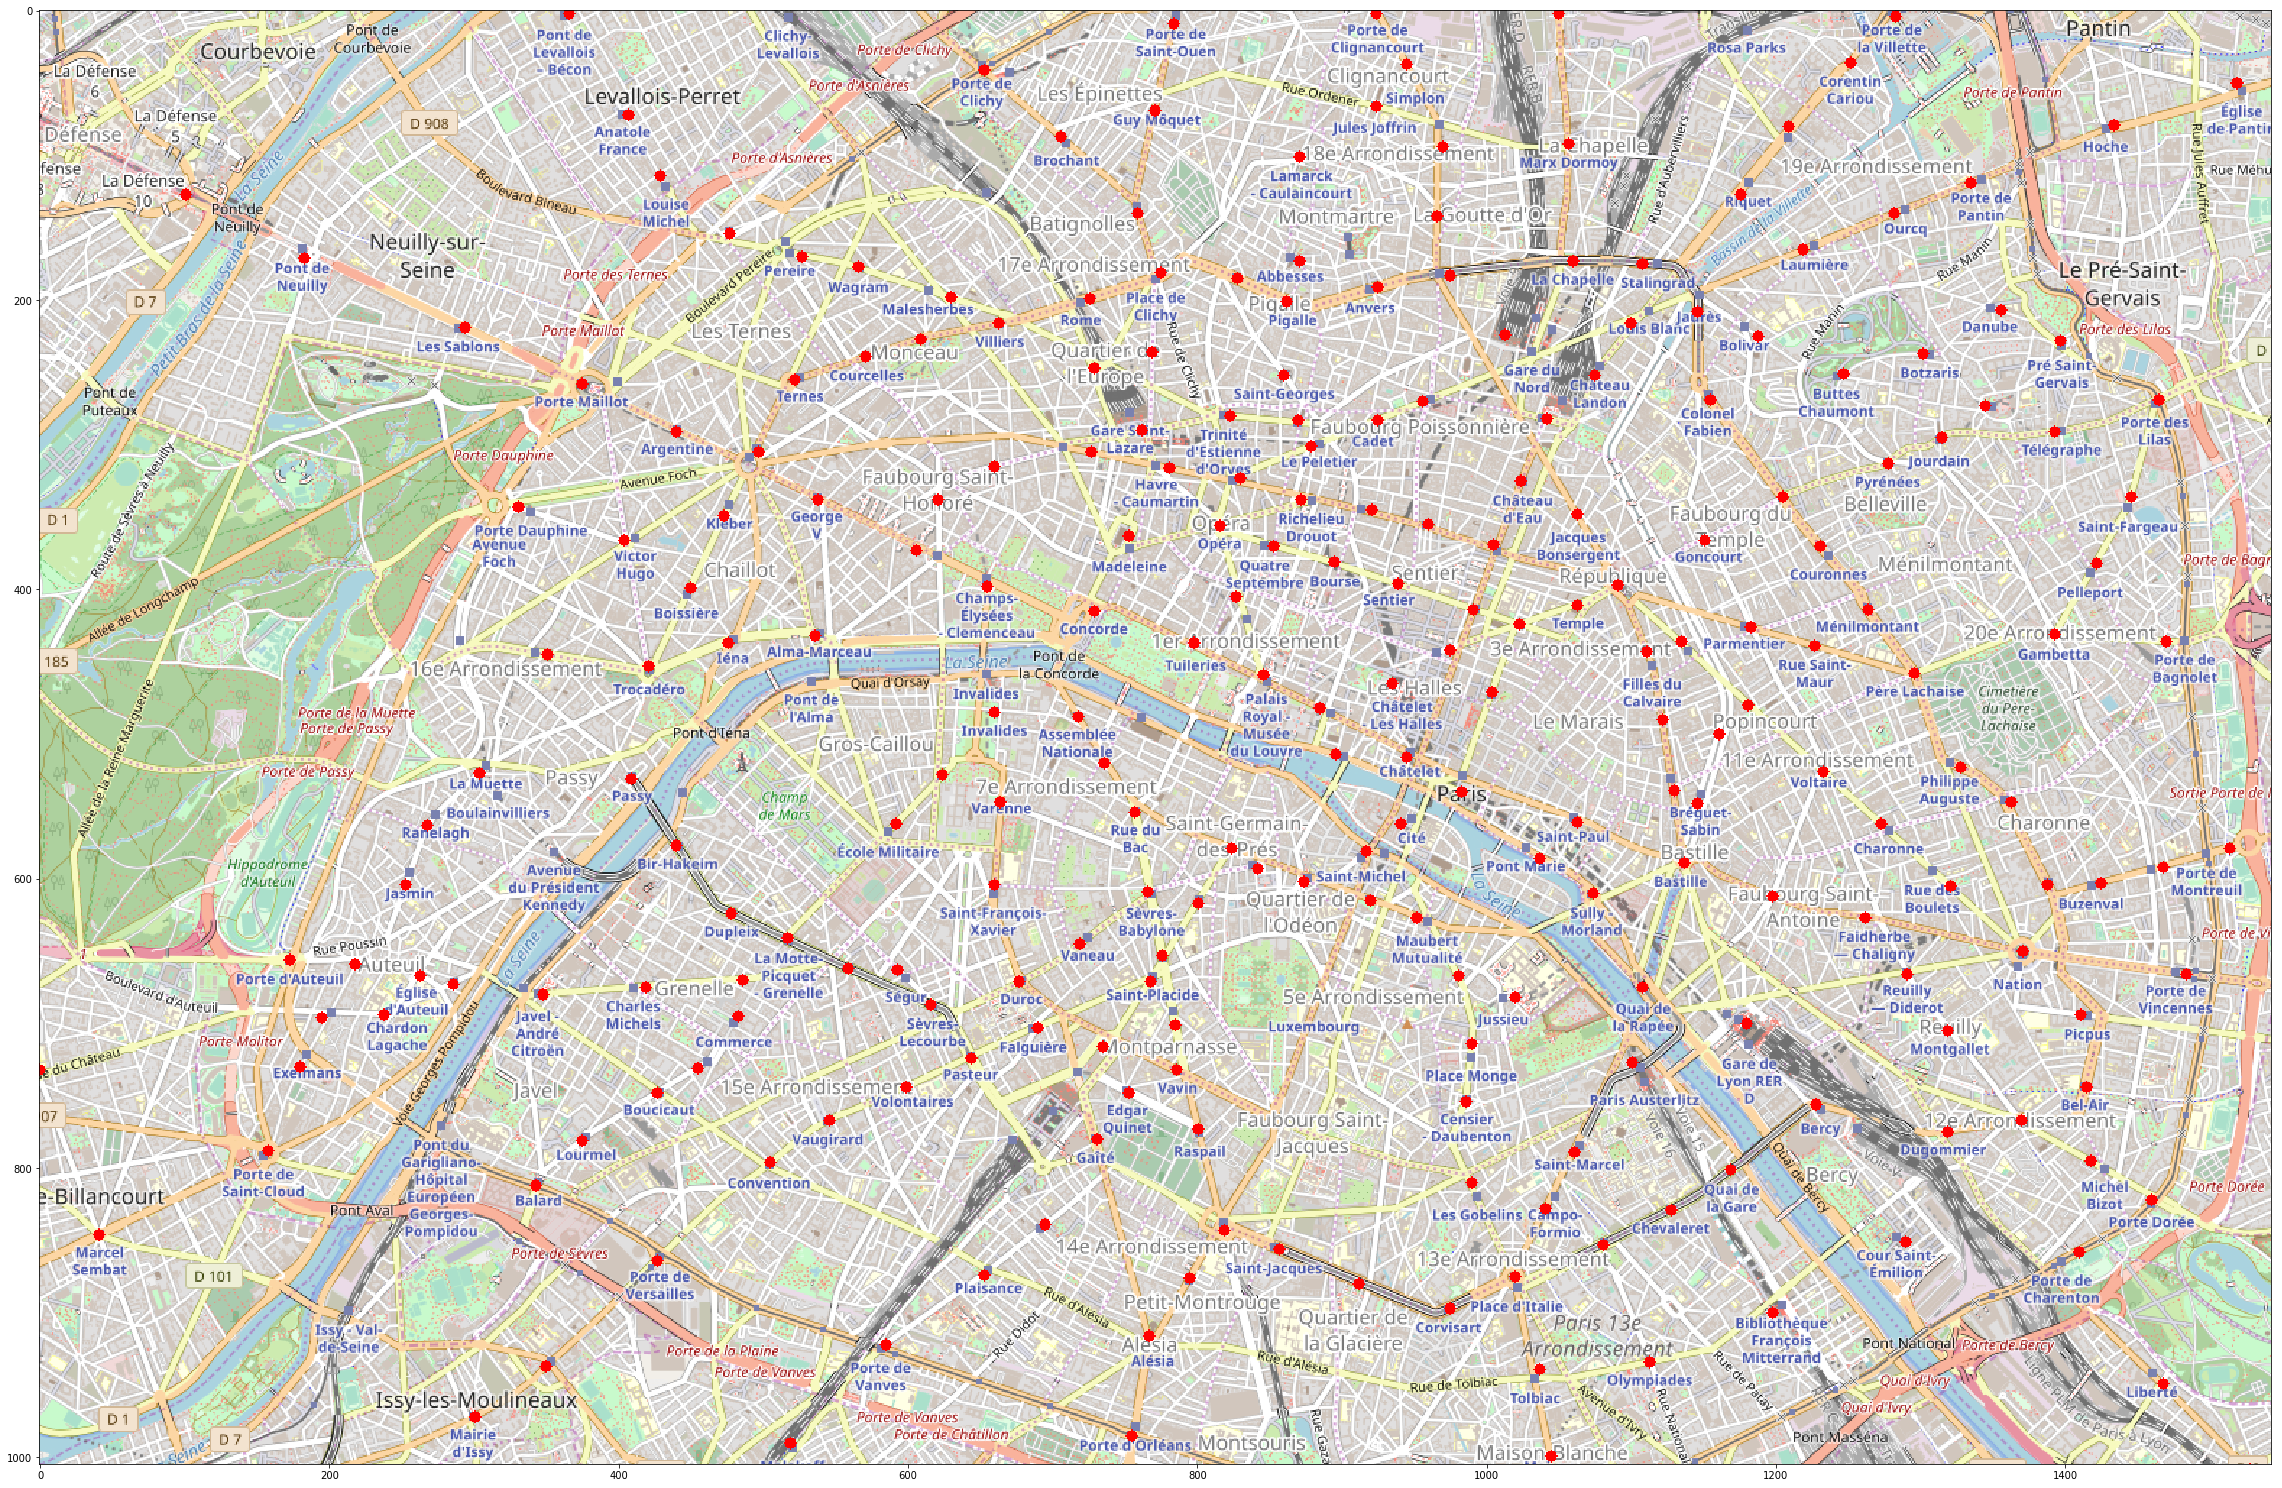

In [5]:
import numpy as np
import cv2
import math
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (40,40)

#VARIABLES THAT DEFINES MY MAP
mapcenterLat=48.8596
mapcenterLong=2.3272
mapscale=119.44   #km to pixel estimation made with illustrator, between muette and fille du calvaire, 6.79KM for 808 and 69px ie 811px
mappng = cv2.imread('map.png')
mapheight, mapwidth = mappng.shape[:2]
mapcenterx=mapwidth/2.0
mapcentery=mapheight/2.0

def convertToDeltaKm(lat,lon):
    dx = (mapcenterLong-lon)*40000*math.cos((lat+mapcenterLat)*math.pi/360)/360
    dy = (lat-mapcenterLat)*40000/360
    return dx,dy

def convertToPixel(lat,long,ratio):
    dx,dy=convertToDeltaKm(lat,long)
    dx=int(mapcenterx*ratio-mapscale*dx)
    dy=int(mapcentery*ratio-mapscale*dy)
    return dx,dy

for index,row in fixdf.iterrows():
    x,y= convertToPixel(row["location"][0],row["location"][1],1)
    cv2.circle(mappng,(x,y), 4, (0,0,255), -1)
   
plt.imshow(cv2.cvtColor(mappng, cv2.COLOR_BGR2RGB))
plt.show()

#Close enough!

## Data building

Now, lets run the script for my station (la muette) and try to convert that to a matrix that we could overlay over the map

In [6]:
#Here I choose my metro station
indexStation=245
myStation=fixdf.loc[indexStation]["stationName"]
#Actually scrape the data (takes some time), and you might want to specify your date and time
date="21/12/2018"
hour="09"
timelist=[]
try:
    with open('data/'+myStation+'.pkl', 'rb') as f:
        timelist = pickle.load(f)
except FileNotFoundError:
    for index,row in fixdf.iterrows():
        if index!=indexStation:
            data=getTime(myStation,row["stationName"],date,hour)
        else:
            data=0
        timelist.append(data)
    with open('data/'+myStation+'.pkl', 'wb') as f:
        pickle.dump(timelist, f)


In [37]:
import scipy.spatial

mapRatio=1.5 #Larger map to account for offscreen stations (might be smarter to geofence the data)
distanceArray=np.ones((int(mapwidth*mapRatio), int(mapheight*mapRatio)))*1000
walkspeed=3  #Km/h, accounts for non flight and stop due to traffic

#Fill the basic data
forimagearay=[]

try:
    with open('data/'+myStation+'array.pkl', 'rb') as f:
        forimagearay = pickle.load(f)
except FileNotFoundError:
    fixdf["locationpixel_x"] = df.apply (lambda row: convertToPixel(row["location"][0],row["location"][1],mapRatio)[0],axis=1)
    fixdf["locationpixel_y"] = df.apply (lambda row: convertToPixel(row["location"][0],row["location"][1],mapRatio)[1],axis=1)
    data_array=fixdf.as_matrix(columns=["locationpixel_x","locationpixel_y"])
    KDtree = scipy.spatial.cKDTree(data_array)
    for x,y in np.ndindex(distanceArray.shape):
        return_data=KDtree.query([x,y])
        index=return_data[1]
        distance=return_data[0]/mapscale #KM
        timewalk=60*distance/walkspeed+float(timelist[index]) #Minutes
        if distanceArray[x,y]>timewalk:
            distanceArray[x,y]=timewalk
     
    forimagearay=distanceArray[int(distanceArray.shape[0]/2-mapwidth/2):int(distanceArray.shape[0]/2+mapwidth/2),int(distanceArray.shape[1]/2-mapheight/2):int(distanceArray.shape[1]/2+mapheight/2)]
    with open('data/'+myStation+'array.pkl', 'wb') as f:
        pickle.dump(forimagearay, f)
    

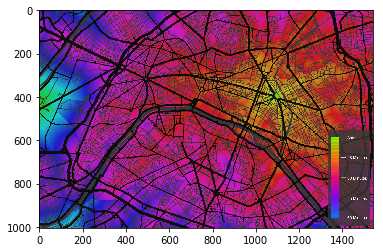

True

In [38]:

with open('data/'+myStation+'array.pkl', 'rb') as f:
     h = pickle.load(f)
h=(np.flipud(np.rot90(forimagearay, 1))).astype(np.uint8)
#We want a one Hour scale
h=h*2
h=180-h
h+=45
s=np.ones(h.shape, dtype=np.  uint8)*220
v=np.ones(h.shape, dtype=np.uint8)*200

def transparentOverlay(src , overlay , pos=(0,0),scale = 1):
    """
    :param src: Input Color Background Image
    :param overlay: transparent Image (BGRA)
    :param pos:  position where the image to be blit.
    :param scale : scale factor of transparent image.
    :return: Resultant Image
    """
    overlay = cv2.resize(overlay,(0,0),fx=scale,fy=scale)
    h,w,_ = overlay.shape  # Size of foreground
    rows,cols,_ = src.shape  # Size of background Image
    y,x = pos[0],pos[1]    # Position of foreground/overlay image
    
    #loop over all pixels and apply the blending equation
    for i in range(h):
        for j in range(w):
            if x+i >= rows or y+j >= cols:
                continue
            alpha = float(overlay[i][j][3]/255.0) # read the alpha channel 
            src[x+i][y+j] = alpha*overlay[i][j][:3]+(1-alpha)*src[x+i][y+j]
    return src


hsv = np.dstack([h, s,v])
rgb=cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
overlay = cv2.imread('mapalpha.png',cv2.IMREAD_UNCHANGED)
overlay=cv2.cvtColor(overlay,cv2.COLOR_BGRA2RGBA)
total = transparentOverlay(rgb,overlay)
plt.imshow(total)
plt.show()
cv2.imwrite('data/'+myStation+'.png',cv2.cvtColor(total,cv2.COLOR_RGB2BGR) )

# Best places to meet 
I live near la Muette and my girlfriend near Mercadet. What is the best place to meet? 

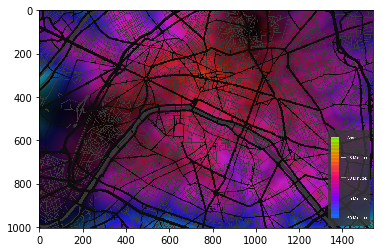

True

In [51]:
with open('data/La Muette (METRO), Parisarray.pkl', 'rb') as f:
     ben = pickle.load(f)
with open('data/Marcadet - Poissonniers (METRO), Parisarray.pkl', 'rb') as f:
     marinette = pickle.load(f)
        
h=(ben+marinette)/2
v=200-5*abs((ben-marinette))
h=(np.flipud(np.rot90(h, 1))).astype(np.uint8)
v=(np.flipud(np.rot90(v, 1))).astype(np.uint8)

h=h*2
h=180-h
h+=45
s=np.ones(h.shape, dtype=np.uint8)*220

hsv = np.dstack([h, s,v])
rgb=cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
overlay = cv2.imread('mapalpha.png',cv2.IMREAD_UNCHANGED)
overlay=cv2.cvtColor(overlay,cv2.COLOR_BGRA2RGBA)
total = transparentOverlay(rgb,overlay)
plt.imshow(total)
plt.show()
cv2.imwrite('data/meetup.png',cv2.cvtColor(total,cv2.COLOR_RGB2BGR) )
#It seems to be around st Lazare